<a href="https://colab.research.google.com/github/sstupUp/Machine_Learning/blob/master/201710870_%EC%95%88%EB%B3%91%EC%B2%A0_LAB05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# utils.py와 cars dataset을 현재 directory로 복사

# !cp /content/drive/MyDrive/Class_pdf/DL/LAB05/utils.py .
# !cp -r /content/drive/MyDrive/Class_pdf/DL/LAB05/cars/ .

In [4]:
# !mkdir ./nets

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [63]:
batch_size = 16
learning_rate = 0.0002
epoch = 50

n_node = 1024
dropratio = 0.5

imgsize = 256

In [39]:
img_dir = 'cars/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

336


In [40]:
# 2. Dev data
# valiadation set

img_dir = 'cars/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    # transforms.Scale(256),
    # transforms.RandomSizedCrop(224),
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [41]:
# 3. Test data

img_dir = 'cars/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    # transforms.Scale(256),
    # transforms.RandomSizedCrop(224),
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [42]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))
#for imgs, labels in train_batch:
#    for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 4
['Convertible', 'SUV', 'Sedan', 'Wagon']
{'Convertible': 0, 'SUV': 1, 'Sedan': 2, 'Wagon': 3}
336
Training: 336, Dev: 112, Test: 112


In [43]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['Convertible', 'SUV', 'Sedan', 'Wagon']
['Convertible', 'SUV', 'Sedan', 'Wagon']
['Convertible', 'SUV', 'Sedan', 'Wagon']


In [44]:
# Pretrained VGG Model
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

# cnt = 0
# for i in model.children():
#    print("yhk[%d]" %cnt)
#    print(i)
#    cnt += 1
    

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [45]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [64]:
# Customized Fully Model

base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, 4*n_node),
            nn.BatchNorm1d(4*n_node),
            nn.ELU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(4*n_node, 2*n_node),
            nn.BatchNorm1d(2*n_node),
            nn.ELU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(2*n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ELU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        
        # weight initialization
        for m in self.layer1.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        # layer0의 사이즈를 프린트하여 확인 가능
        # print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        
        return out

In [65]:
# Model on GPU
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = True

In [66]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [67]:
# OPtimizer & Loss

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

In [68]:
# Train

import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train == False):
    # netname = './nets/media_vgg19_fixed.pkl'
    netname = './nets/cars_vgg_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    
    model.train()
    
    netname = './nets/cars_vgg19'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0 - train_corr)
    y_dev_err.append(100.0 - dev_corr)
    y_test_err.append(100.0 - test_corr)
    
    # 학습을 재시작한다면
    # netname = '../nets/media_pre_vgg19.pkl'
    # model = torch.load(netname)
    # 파라미터 학습 여부
    # for params in model.layer0.parameters():
    #     parmas.required_grad = False
    # for params in model.layer1.aprameters():
    #     params.required_grad = True
    
    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i)
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
        
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        
        if(i % disp_step == 0) or (i == epoch - 1):
            torch.save(model, netname + '_%d.pkl'%i)
            print("\n[%d / %d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy()))
            model.eval()
            
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            # graph
            x_epoch.append(i+1)
            y_train_err.append(100.0 - train_corr)
            y_dev_err.append(100.0 - dev_corr)
            y_test_err.append(100.0 - test_corr)
            
    print("Total Time: %.2f sec" %total_time)            

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 20.83, dev: 20.54, test: 24.11
0..

[0 / 50] loss: 1.466, 
Correct of train: 36.31, dev: 27.68, test: 24.11
time: 4.33 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10 / 50] loss: 1.018, 
Correct of train: 53.27, dev: 63.39, test: 62.50
time: 47.49 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..
20..

[20 / 50] loss: 0.672, 
Correct of train: 62.80, dev: 69.64, test: 67.86
time: 90.68 sec..
21..
22..
23..
24..
25..
26..
27..
28..
29..
30..

[30 / 50] loss: 0.934, 
Correct of train: 63.39, dev: 58.04, test: 60.71
time: 133.83 sec..
31..
32..
33..
34..
35..
36..
37..
38..
39..
40..

[40 / 50] loss: 1.012, 
Correct of train: 71.13, dev: 73.21, test: 66.96
time: 176.95 sec..
41..
42..
43..
44..
45..
46..
47..
48..
49..

[49 / 50] loss: 0.480, 
Correct of train: 72.32, dev: 71.43, test: 74.11
time: 215.75 sec..
Total Time: 215.75 sec


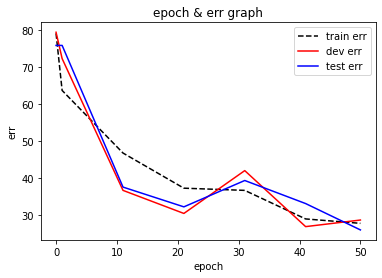

In [69]:
# epoch_err curve
if (to_train):
  plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
  plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
  plt.plot(x_epoch, y_test_err, color='blue', label='test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc='upper right')
  plt.show()

Normalized confusion matrix


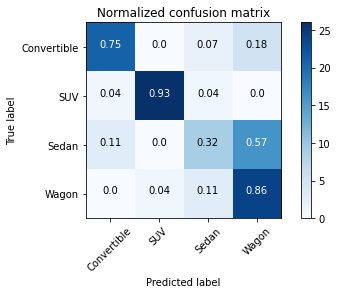

Confusion matrix, without normalization


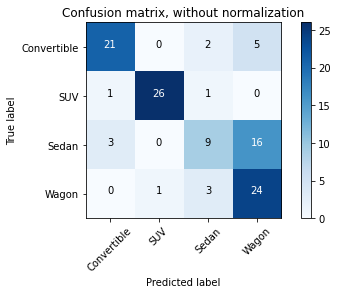

	 acc  |	 pre  |	 rec  |	 f1
 Convertible: 0.90 |	 0.84 |	 0.75 |	 0.79
 SUV: 0.88 |	 0.96 |	 0.93 |	 0.95
 Sedan: 0.72 |	 0.60 |	 0.32 |	 0.42
 Wagon: 0.78 |	 0.53 |	 0.86 |	 0.66
*accuracy: 0.82, precision: 0.73, recall: 0.71, *f1 score: 0.70
[AP]
Convertible: 0.90
SUV: 0.99
Sedan: 0.58
Wagon: 0.76

[mAP] 0.808
[miAP] 0.913


(array([1, 3, 3, 1, 0, 2, 0, 3, 3, 1, 0, 3, 3, 1, 2, 3, 3, 1, 1, 1, 2, 1,
        0, 2, 0, 2, 0, 3, 0, 1, 1, 2, 3, 3, 0, 2, 3, 3, 0, 0, 3, 1, 3, 0,
        3, 2, 3, 3, 1, 1, 2, 1, 3, 1, 1, 2, 3, 3, 1, 2, 1, 3, 3, 0, 3, 3,
        0, 3, 3, 1, 1, 3, 0, 0, 0, 3, 0, 3, 1, 0, 3, 0, 1, 1, 3, 0, 3, 2,
        3, 3, 3, 2, 0, 1, 1, 0, 3, 3, 3, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 1,
        3, 2]),
 array([1, 2, 2, 1, 0, 3, 0, 3, 2, 1, 2, 3, 2, 1, 2, 3, 3, 1, 1, 1, 3, 1,
        0, 3, 0, 2, 0, 2, 0, 1, 1, 2, 2, 2, 0, 2, 3, 3, 0, 0, 3, 1, 2, 1,
        3, 0, 3, 2, 1, 1, 0, 1, 3, 1, 3, 2, 3, 2, 1, 2, 1, 3, 0, 0, 3, 2,
        0, 0, 3, 1, 1, 2, 2, 0, 0, 3, 0, 2, 1, 0, 0, 0, 1, 1, 3, 0, 3, 1,
        3, 3, 2, 2, 2, 1, 1, 0, 0, 2, 3, 3, 0, 0, 0, 3, 2, 3, 0, 2, 1, 1,
        3, 2]),
 array([0.49922061, 0.53702968, 0.46716961, 0.98200071, 0.81045008,
        0.81782418, 0.98869443, 0.81788534, 0.64618975, 0.9999842 ,
        0.46673992, 0.98724115, 0.73395419, 0.80652744, 0.66083056,
        0.95544505, 0.98

In [70]:
# Evaluation for dev & test data
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


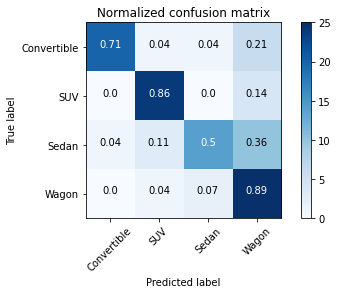

Confusion matrix, without normalization


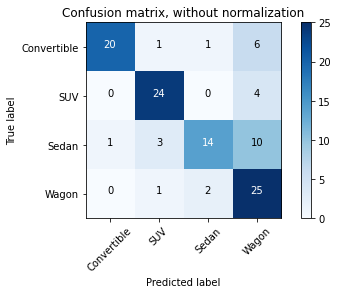

	 acc  |	 pre  |	 rec  |	 f1
 Convertible: 0.92 |	 0.95 |	 0.71 |	 0.82
 SUV: 0.85 |	 0.83 |	 0.86 |	 0.84
 Sedan: 0.75 |	 0.82 |	 0.50 |	 0.62
 Wagon: 0.79 |	 0.56 |	 0.89 |	 0.68
*accuracy: 0.83, precision: 0.79, recall: 0.74, *f1 score: 0.74
[AP]
Convertible: 0.91
SUV: 0.94
Sedan: 0.78
Wagon: 0.77

[mAP] 0.848
[miAP] 0.900


In [71]:
model.eval()
_, _, _ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: Convertible
 True predicted images/total Convertible category: 21 / 28
Predicted probability:
[0.8910089  0.0010089  0.10639103 0.00159115]


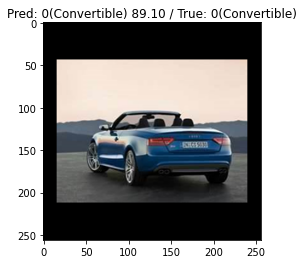

 False predicted images/total Convertible category: 7 / 28
Predicted probability:
[4.0472194e-04 2.0313372e-03 5.3049367e-02 9.4451457e-01]


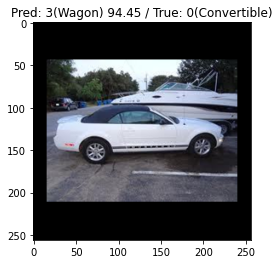

Category: SUV
 True predicted images/total SUV category: 26 / 28
Predicted probability:
[2.0875463e-04 9.0332103e-01 1.1269862e-02 8.5200369e-02]


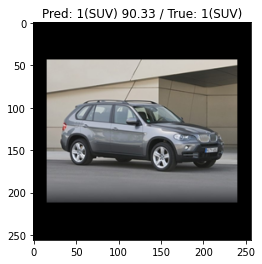

 False predicted images/total SUV category: 2 / 28
Predicted probability:
[0.49714947 0.3275033  0.0919465  0.08340073]


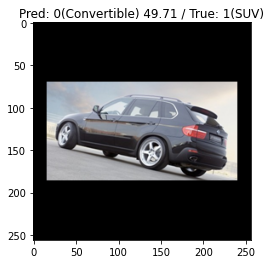

Category: Sedan
 True predicted images/total Sedan category: 9 / 28
Predicted probability:
[0.02535353 0.05426561 0.90499765 0.0153832 ]


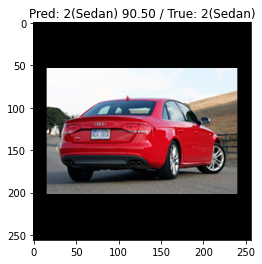

 False predicted images/total Sedan category: 19 / 28
Predicted probability:
[0.45410365 0.11154    0.2590155  0.17534085]


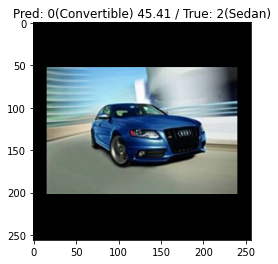

Category: Wagon
 True predicted images/total Wagon category: 24 / 28
Predicted probability:
[7.1855880e-05 4.2391745e-03 2.3285646e-03 9.9336040e-01]


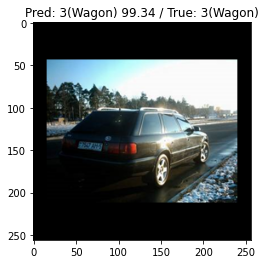

 False predicted images/total Wagon category: 4 / 28
Predicted probability:
[0.00626975 0.5237497  0.22084281 0.24913773]


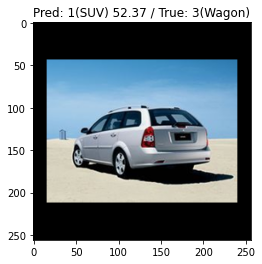

In [72]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=1)